<p style="font-size: 30px; line-height: 135%;}">
<b>3 Análisis de emociones en tweets</b>
</p>

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import nltk
#nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from IPython.display import display

<p style="font-size: 25px; line-height: 135%;}">
<b>Parte 3, pregunta a</b>
</p>

In [2]:
df = pd.read_csv('./text_emotion.csv')
pd.options.display.max_colwidth = 150
display(df.head(5))

print(df.shape)
print("Existen %i clases" % len(set(df.iloc[:,1])))
print(Counter(df.iloc[:,1]))

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will."


(40000, 4)
Existen 13 clases
Counter({'neutral': 8638, 'worry': 8459, 'happiness': 5209, 'sadness': 5165, 'love': 3842, 'surprise': 2187, 'fun': 1776, 'relief': 1526, 'hate': 1323, 'empty': 827, 'enthusiasm': 759, 'boredom': 179, 'anger': 110})


<p style="font-size: 18px; line-height: 135%;}">
<b>a)</b>
El dataset está compuesto por 40000 registros, cada registro que corresponde a un tweet contiene id, autor, contenido del tweet y una clase de sentiemiento.
Existe un total de 13 clases.
</p>

<p style="font-size: 25px; line-height: 135%;}">
<b>Parte 3, pregunta c</b>
</p>

In [3]:
for i in range(len(df.index)):
    df.ix[i,3] = df.iloc[i,3].lower()
    df.ix[i,3] = re.sub('[^\w]', ' ', df.iloc[i,3])
    df.ix[i,3] = re.sub(r' +' ,' ', df.iloc[i,3])
    df.ix[i,3] = re.sub(r'^ +' ,'', df.iloc[i,3])

stops = set(stopwords.words('english'))
split_content = [line.split() for line in df.iloc[:,3]]
lemma = WordNetLemmatizer()
for i in range(len(df.index)):
    aux = [lemma.lemmatize(word) for word in split_content[i]]
    df.iloc[i,3] = ' '.join([word for word in aux if word not in stops])

<p style="font-size: 18px; line-height: 135%;}">
<b>c)</b>
Para el preprocesamiento se eliminan puntuciones y simbolos, además de hacer una lematización para las palabras. Más adelante al crear 'bag of words' con la función countervectorizer se eliminan las palabras que aparecen menos de 5 veces en el total de tweet con el objeto de eliminar aquellas palabras mal escritas y nombres propios que no suelen repetirse y no tienen incidencia en la polaridad del tweet.
</p>

<p style="font-size: 25px; line-height: 135%;}">
<b>Parte 3, pregunta b y d</b>
</p>

In [5]:
df_feliz = df[(df['sentiment'] == 'happiness')].copy()
df_triste = df[(df['sentiment'] == 'sadness')].copy()

clase_feliz = [1 for x in range(len(df_feliz.index))]
clase_triste = [-1 for x in range(len(df_triste.index))]

clase_feliz = pd.Series(clase_feliz)
clase_triste = pd.Series(clase_triste)

df_feliz['clase'] = clase_feliz.values
df_triste['clase'] = clase_triste.values

df_train = pd.DataFrame(columns = df_feliz.columns)
df_test = pd.DataFrame(columns = df_feliz.columns)

msk = np.random.rand(len(df_feliz)) < 0.8
df_train = df_train.append(df_feliz[msk], ignore_index=True)
df_test = df_test.append(df_feliz[~msk], ignore_index=True)

msk = np.random.rand(len(df_triste)) < 0.8
df_train = df_train.append(df_triste[msk], ignore_index=True)
df_test = df_test.append(df_triste[~msk], ignore_index=True)

df_test['clase'] = df_test["clase"].astype(int)
df_train['clase'] = df_train["clase"].astype(int)

#display(df_test.head())

<p style="font-size: 18px; line-height: 135%;}">
<b>b) y  d)</b>
En esta parte para evitar el desbalanceo que podría generar una mala máquina en casos como las que corresponden a árboles, se toman solo dos clases que son las de felicidad y tristeza. Se usan solo estás dos clases ya que además de poseer casi la misma cantidad de datos son espcialmente útiles como clasificación binaria de positivo y negativo si se considera que tristeza puede traducirse como no felicidad, por otro lado es díficil incluir todas las 13 clases del dataset y clasificarlas de forma binaria ya que son sentimientos muy variados, además se tiene la clase neutral que no corresponde a una polaridad, es decir, no es una opinión/sentimiento si no que más bien corresponden a comentarios.

Notar como se dividen los dataset de pruebas, se busca que quede balanceado también en el sentido de la cantidad de elemetnos de cada clase en el set de train y test. Además es más justo la valoración de las métricas por clase
</p>

<p style="font-size: 25px; line-height: 135%;}">
<b>Parte 3, pregunta e</b>
</p>

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df = 5)
cv_train = cv.fit_transform(df_train.iloc[:, 3])

cv_test = cv.transform(df_test.iloc[:, 3])
#print(cv.get_feature_names())

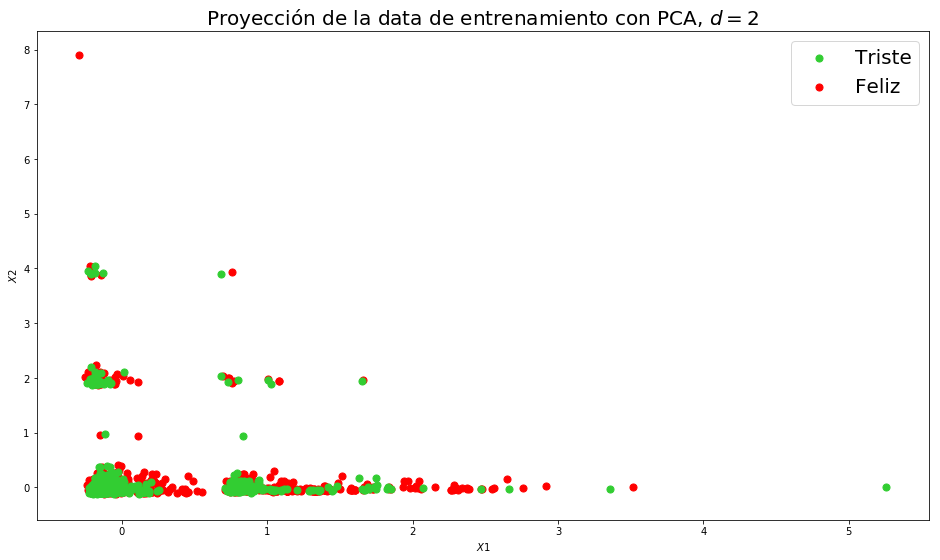

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
d=2
pca_model = PCA(n_components=d)
pca_model.fit(cv_train.toarray())
X_pca_train = pca_model.transform(cv_train.toarray())

#Se procede a gráficar los elementos
plt.figure(figsize = (16, 9))

for i in range(len(X_pca_train)):
    if df_train.iloc[i,4] == -1:
        p1 = plt.scatter(X_pca_train[i,0], X_pca_train[i,1], s=50, c = "limegreen")
    elif df_train.iloc[i,4] == 1:
        p2 = plt.scatter(X_pca_train[i,0], X_pca_train[i,1], s=50, c = "red")

plt.legend([p1, p2], ["Triste", "Feliz"], prop={'size': 20})
        
plt.xlabel("$X1$")
plt.ylabel("$X2$")
plt.title("Proyección de la data de entrenamiento con PCA, $d = "+str(d)+"$", size = 20)
plt.show()

<p style="font-size: 18px; line-height: 135%;}">
<b>e)</b>
Para construir el modelo bag of words se utiliza la función CounterVectorizer incluida en el paquete sklearn, se incluye una tolerancia de palabras admitidas con un mínimo de 5 apariciones. Hacer lo anterior es importante por dos motivos, el primero es que así se evita incluir palabras que están mal escritas o nombres de cuentas de twitter citados en los mismo tweets, las cuales no tendrían una mayor incidencia en el resultado de las predicciones, además como segundo y resultado de eliminar estás palabras 'basura' se logra disminuir la dimensionalidad lo que se traduce en desempeño computacional de la máquina.

Para tener una vaga idea de como se distriuyen los datos se usa PCA para poder visualizarlos en un gráfico 2D
</p>

<p style="font-size: 25px; line-height: 135%;}">
<b>Parte 3, pregunta f y g</b>
</p>

In [8]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier

m_svm = SVC()
m_svm.set_params(kernel = 'linear')

m_svmRBF = SVC()
m_svmRBF.set_params(kernel = 'rbf')

verdad = df_train.iloc[:, 4]

m_svm.fit(cv_train, verdad)
m_svmRBF.fit(cv_train, verdad)

m_lr = LogisticRegression()
m_lr.fit(cv_train, verdad)

m_qda = QuadraticDiscriminantAnalysis()
#m_qda.fit(cv_train.toarray(), df_train.iloc[:, 4])

m_lda = LinearDiscriminantAnalysis()
m_lda.fit(cv_train.toarray(), verdad)

m_mnb = MultinomialNB()
m_mnb.fit(cv_train, verdad)

m_bnb = BernoulliNB()
m_bnb.fit(cv_train, verdad)

m_rfc = RandomForestClassifier()
m_rfc.fit(cv_train, verdad)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [9]:
from sklearn.metrics import classification_report
def score_the_model(model,x,y,xt,yt):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt[:-1],yt[:-1])
    print("Training Accuracy: %f" % (acc_tr))
    print("Test Accuracy: %f" % (acc_test))
    print("Detailed Analysis Testing Results ...")
    print(classification_report(yt, model.predict(xt), target_names=['+','-']))
    acc_train_all.append(acc_tr)
    acc_test_all.append(acc_test)

In [10]:
acc_train_all = list()
acc_test_all = list()

score_the_model(m_svmRBF, cv_train, df_train.iloc[:,4], cv_test, df_test.iloc[:,4])
score_the_model(m_svm, cv_train, df_train.iloc[:,4], cv_test, df_test.iloc[:,4])
score_the_model(m_lr, cv_train, df_train.iloc[:,4], cv_test, df_test.iloc[:,4])
score_the_model(m_lda, cv_train, df_train.iloc[:,4], cv_test, df_test.iloc[:,4])
score_the_model(m_mnb, cv_train, df_train.iloc[:,4], cv_test, df_test.iloc[:,4])
score_the_model(m_bnb, cv_train, df_train.iloc[:,4], cv_test, df_test.iloc[:,4])
score_the_model(m_rfc, cv_train, df_train.iloc[:,4], cv_test, df_test.iloc[:,4])

Training Accuracy: 0.572222
Test Accuracy: 0.559444
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.94      0.14      0.24      1056
          -       0.53      0.99      0.69      1031

avg / total       0.73      0.56      0.46      2087

Training Accuracy: 0.881380
Test Accuracy: 0.785235
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.79      0.79      0.79      1056
          -       0.78      0.78      0.78      1031

avg / total       0.79      0.79      0.79      2087

Training Accuracy: 0.868348
Test Accuracy: 0.797220
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.81      0.79      0.80      1056
          -       0.79      0.81      0.80      1031

avg / total       0.80      0.80      0.80      2087

Training Accuracy: 0.872330
Test Accuracy: 0.777085
Detailed Analysis Testing Results

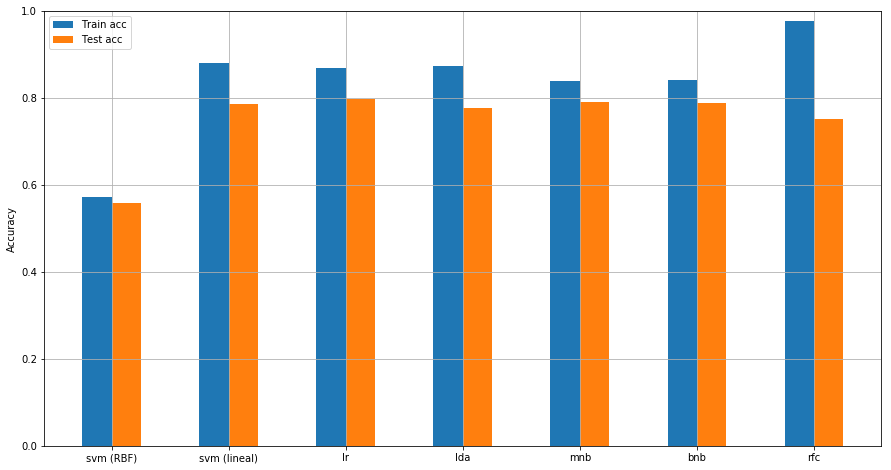

In [11]:
import matplotlib.pyplot as plt

nom = list(['svm (RBF)','svm (lineal)', 'lr', 'lda', 'mnb', 'bnb', 'rfc'])
pos = list(range(7))
width = 0.25

acc_train_all = np.array(acc_train_all)

fig, ax = plt.subplots(figsize=(15,8))

plt.bar(pos, acc_train_all, width)
plt.bar([p + width for p in pos], acc_test_all, width)

ax.set_ylabel('Accuracy')

ax.set_xticks([p + width*0.5 for p in pos])
ax.set_xticklabels(nom)

plt.ylim([0,1])
plt.legend(['Train acc', 'Test acc'], loc='upper left')
plt.grid()

plt.show()

<p style="font-size: 18px; line-height: 135%;}">
<b>f)</b>
De los modelos utilizados con sus parámetros por defecto, el que presenta un peor comportamiento es SVM, mientras que el resto de las 4 máquinas tienen un desempeño similar alcanzando una cota para la exactitud que llega al 80% en las prediciones para el set de pruebas. Notar como la máquina de árboles de decisión en la 'accuracy' para el set de entrenamiento es cercana al 100%, esto es explicable si se considera que el algoritmo hizo las suficientes operaciones y tiene una cantidad de hojas justas para ajustar el modelo de excelente manera a los datos con los que fue entrenado.
</p>

<p style="font-size: 18px; line-height: 135%;}">
<b>g)</b>
Las métricas corresponden a:<br><br>
<b>Accuracy:</b> Es la exactitud, es decir, los resultados que fueron correctos sobre el total de resultados. 
<br>
<b>Precision:</b> La precision se refiere a la relación de verdaderos positivos sobre la clase positiva. Por ejemplo para el caso de la clase positiva, la métrica evaluará todos los resultados correctos de la clase positiva todos los resuldos predichos de clase positiva independiente de si fueron correctos.
<br>
<b>Recall:</b> Similar a precision, hace referencia a la relación de verdaderos positivos sobre el total de verdaderos positivos y falsos negativos. Por ejemplo para el caso de la clase positiva, la métrica evaluará todos los resultados correctos de la clase positiva sobre la cantidad de resultados correctos posibles.
<br>
<b>F1-Score:</b> Métrica desde 0 a 1, siendo 1 el mejor. Es una relación mesurada que incluye precision y recall.
<br><br>
Si huebiera que tomar una decisioón sobre cual métrica utilizar cuando se quiera mostrar a alguien sin conocimientos cual es la mejor máquina, sin duda la mejor métrica para el desempeño es la 'accuracy'. Es de más fácil interpretación siendo esta en que porcentaje de casos para los que se probo la máquina es exitosa.

<p style="font-size: 25px; line-height: 135%;}">
<b>Parte 3, pregunta i</b>
</p>

In [37]:
df_neutral = df[(df['sentiment'] == 'neutral')].copy()
df_worry = df[(df['sentiment'] == 'worry')].copy()
df_happiness = df[(df['sentiment'] == 'happiness')].copy()
df_sadness = df[(df['sentiment'] == 'sadness')].copy()
df_love = df[(df['sentiment'] == 'love')].copy()
df_surprise = df[(df['sentiment'] == 'surprise')].copy()
df_fun = df[(df['sentiment'] == 'fun')].copy()
df_relief = df[(df['sentiment'] == 'relief')].copy()
df_hate = df[(df['sentiment'] == 'hate')].copy()
df_empty = df[(df['sentiment'] == 'empty')].copy()
df_enthusiasm = df[(df['sentiment'] == 'enthusiasm')].copy()
df_boredom = df[(df['sentiment'] == 'boredom')].copy()
df_anger = df[(df['sentiment'] == 'anger')].copy()

clase_neutral = [0 for x in range(len(df_neutral.index))]
clase_worry = [1 for x in range(len(df_worry.index))]
clase_happiness = [2 for x in range(len(df_happiness.index))]
clase_sadness = [3 for x in range(len(df_sadness.index))]
clase_love = [4 for x in range(len(df_love.index))]
clase_surprise = [5 for x in range(len(df_surprise.index))]
clase_fun = [6 for x in range(len(df_fun.index))]
clase_relief = [7 for x in range(len(df_relief.index))]
clase_hate = [8 for x in range(len(df_hate.index))]
clase_empty = [9 for x in range(len(df_empty.index))]
clase_enthusiasm = [10 for x in range(len(df_enthusiasm.index))]
clase_boredom = [13 for x in range(len(df_boredom.index))]
clase_anger = [14 for x in range(len(df_anger.index))]

clase_neutral = pd.Series(clase_neutral)
clase_worry = pd.Series(clase_worry)
clase_happiness = pd.Series(clase_happiness)
clase_sadness = pd.Series(clase_sadness)
clase_love = pd.Series(clase_love)
clase_surprise = pd.Series(clase_surprise)
clase_fun = pd.Series(clase_fun)
clase_relief = pd.Series(clase_relief)
clase_hate = pd.Series(clase_hate)
clase_empty = pd.Series(clase_empty)
clase_enthusiasm = pd.Series(clase_enthusiasm)
clase_boredom = pd.Series(clase_boredom)
clase_anger = pd.Series(clase_anger)

df_neutral['clase'] = clase_neutral.values
df_worry['clase'] = clase_worry.values
df_happiness['clase'] = clase_happiness.values
df_sadness['clase'] = clase_sadness.values
df_love['clase'] = clase_love.values
df_surprise['clase'] = clase_surprise.values
df_fun['clase'] = clase_fun.values
df_relief['clase'] = clase_relief.values
df_hate['clase'] = clase_hate.values
df_empty['clase'] = clase_empty.values
df_enthusiasm['clase'] = clase_enthusiasm.values
df_boredom['clase'] = clase_boredom.values
df_anger['clase'] = clase_anger.values

df_train_2 = pd.DataFrame(columns = df_neutral.columns)
df_test_2 = pd.DataFrame(columns = df_neutral.columns)

msk = np.random.rand(len(df_neutral)) < 0.8
#df_train_2 = df_train_2.append(df_neutral[msk], ignore_index=True)
#df_test_2 = df_test_2.append(df_neutral[~msk], ignore_index=True)

msk = np.random.rand(len(df_worry)) < 0.8
#df_train_2 = df_train_2.append(df_worry[msk], ignore_index=True)
#df_test_2 = df_test_2.append(df_worry[~msk], ignore_index=True)

msk = np.random.rand(len(df_happiness)) < 0.8
#df_train_2 = df_train_2.append(df_happiness[msk], ignore_index=True)
#df_test_2 = df_test_2.append(df_happiness[~msk], ignore_index=True)

msk = np.random.rand(len(df_sadness)) < 0.8
#df_train_2 = df_train_2.append(df_sadness[msk], ignore_index=True)
#df_test_2 = df_test_2.append(df_sadness[~msk], ignore_index=True)

msk = np.random.rand(len(df_love)) < 0.8
df_train_2 = df_train_2.append(df_love[msk], ignore_index=True)
df_test_2 = df_test_2.append(df_love[~msk], ignore_index=True)

msk = np.random.rand(len(df_surprise)) < 0.8
df_train_2 = df_train_2.append(df_surprise[msk], ignore_index=True)
df_test_2 = df_test_2.append(df_surprise[~msk], ignore_index=True)

msk = np.random.rand(len(df_fun)) < 0.8
df_train_2 = df_train_2.append(df_fun[msk], ignore_index=True)
df_test_2 = df_test_2.append(df_fun[~msk], ignore_index=True)

msk = np.random.rand(len(df_relief)) < 0.8
df_train_2 = df_train_2.append(df_relief[msk], ignore_index=True)
df_test_2 = df_test_2.append(df_relief[~msk], ignore_index=True)

msk = np.random.rand(len(df_hate)) < 0.8
#df_train_2 = df_train_2.append(df_hate[msk], ignore_index=True)
#df_test_2 = df_test_2.append(df_hate[~msk], ignore_index=True)

msk = np.random.rand(len(df_empty)) < 0.8
#df_train_2 = df_train_2.append(df_empty[msk], ignore_index=True)
#df_test_2 = df_test_2.append(df_empty[~msk], ignore_index=True)

msk = np.random.rand(len(df_enthusiasm)) < 0.8
#df_train_2 = df_train_2.append(df_enthusiasm[msk], ignore_index=True)
#df_test_2 = df_test_2.append(df_enthusiasm[~msk], ignore_index=True)

msk = np.random.rand(len(df_boredom)) < 0.8
#df_train_2 = df_train_2.append(df_boredom[msk], ignore_index=True)
#df_test_2 = df_test_2.append(df_boredom[~msk], ignore_index=True)

msk = np.random.rand(len(df_anger)) < 0.8
#df_train_2 = df_train_2.append(df_anger[msk], ignore_index=True)
#df_test_2 = df_test_2.append(df_anger[~msk], ignore_index=True)

df_train_2["clase"] = df_train_2["clase"].astype(int)
df_test_2["clase"] = df_test_2["clase"].astype(int)

In [38]:
print(df_test_2.shape)

(1849, 5)


<p style="font-size: 18px; line-height: 135%;}">
<b>h)</b>
Igual que de la forma anterior se divide el set de tal forma que la cantidad de elementos de cierta clase que quedan en el test set es equitativa a la que queda en el trainig set (en porcentaje).

Por motivos de memoria no se incluye la totalidad de clases, se quitan las dos con más elementos que son neutral y worry

Con el mismo objeto de reducir el gasto de memoria y tiempo en correr se seleccionan solo ciertas clases (4 en total, hubiera sido bueno probar a reducir la cantidad de elementos por clase y dejar los datos balanceados)
</p>

<p style="font-size: 25px; line-height: 135%;}">
<b>Parte 3, pregunta j</b>
</p>

In [39]:
cv = CountVectorizer(min_df = 5)
cv_train_2 = cv.fit_transform(df_train_2.iloc[:, 3])
cv_test_2 = cv.transform(df_test_2.iloc[:, 3])

acc_train_all = list()
acc_test_all = list()

m_mnb = BernoulliNB()
m_mnb.fit(cv_train_2, df_train_2.iloc[:, 4])
acc_train_all.append(m_mnb.score(cv_train_2, df_train_2.iloc[:,4]))
acc_test_all.append(m_mnb.score(cv_test_2, df_test_2.iloc[:, 4]))

m_lda = LinearDiscriminantAnalysis()
m_lda.fit(cv_train_2.toarray(), df_train_2.iloc[:, 4])
acc_train_all.append(m_lda.score(cv_train_2, df_train_2.iloc[:,4]))
acc_test_all.append(m_lda.score(cv_test_2, df_test_2.iloc[:, 4]))

m_lr = LogisticRegression()
m_lr.set_params(multi_class='multinomial', solver='newton-cg')
m_lr.fit(cv_train_2.toarray(), df_train_2.iloc[:, 4])
acc_train_all.append(m_lr.score(cv_train_2, df_train_2.iloc[:,4]))
acc_test_all.append(m_lr.score(cv_test_2, df_test_2.iloc[:, 4]))

m_rfc = RandomForestClassifier()
m_rfc.fit(cv_train_2.toarray(), df_train_2.iloc[:, 4])
acc_train_all.append(m_rfc.score(cv_train_2, df_train_2.iloc[:,4]))
acc_test_all.append(m_rfc.score(cv_test_2, df_test_2.iloc[:, 4]))

C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


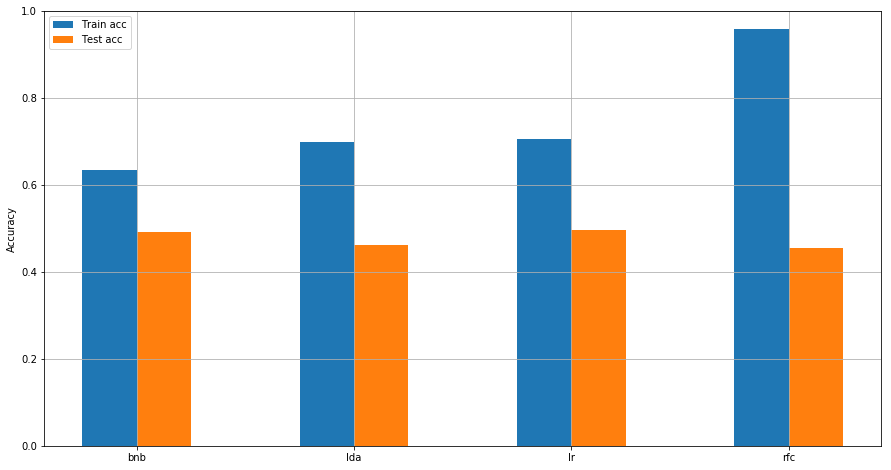

In [40]:
import matplotlib.pyplot as plt

nom = list(['bnb', 'lda', 'lr', 'rfc'])
pos = list(range(4))
width = 0.25

acc_train_all = np.array(acc_train_all)

fig, ax = plt.subplots(figsize=(15,8))

plt.bar(pos, acc_train_all, width)
plt.bar([p + width for p in pos], acc_test_all, width)

ax.set_ylabel('Accuracy')

ax.set_xticks([p + width*0.5 for p in pos])
ax.set_xticklabels(nom)

plt.ylim([0,1])
plt.legend(['Train acc', 'Test acc'], loc='upper left')
plt.grid()

plt.show()

<p style="font-size: 18px; line-height: 135%;}">
<b>j)</b>
Para este caso donde se trabaja con multiples clases, se utilizan 4 diferentes máquinas las cuales se desempeñan de peor manera al ser llevadas a múltiples clases. Se observa como ocurre el mismo fénomeno para el error de entrenamiento en la máquina de árboles.
</p>

<p style="font-size: 25px; line-height: 135%;}">
<b>Parte 3, pregunta k</b>
</p>

In [41]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

acc_train_all = list()
acc_test_all = list()

m_svm_ovr = OneVsRestClassifier(SVC())
m_svm_ovr.fit(cv_train_2, df_train_2.iloc[:, 4])
acc_train_all.append(m_svm_ovr.score(cv_train_2, df_train_2.iloc[:,4]))
acc_test_all.append(m_svm_ovr.score(cv_test_2, df_test_2.iloc[:, 4]))

m_svm_ovo = OneVsOneClassifier(SVC())
m_svm_ovo.fit(cv_train_2, df_train_2.iloc[:, 4])
acc_train_all.append(m_svm_ovo.score(cv_train_2, df_train_2.iloc[:,4]))
acc_test_all.append(m_svm_ovo.score(cv_test_2, df_test_2.iloc[:, 4]))

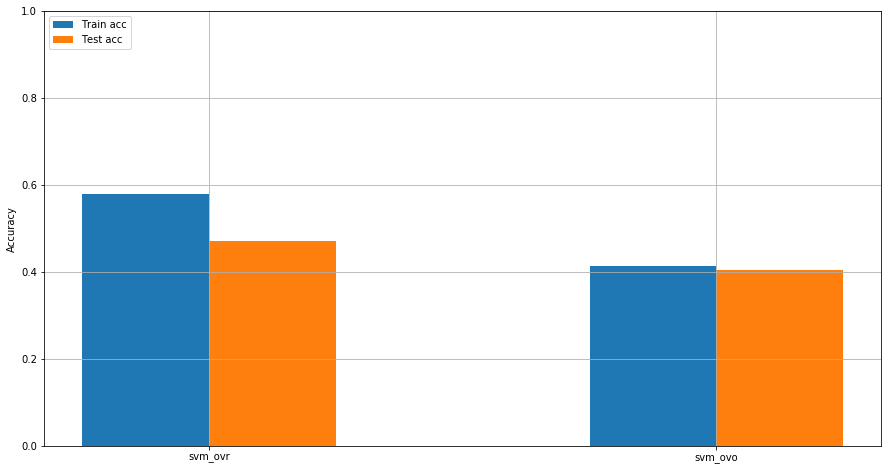

In [42]:
nom = list(['svm_ovr', 'svm_ovo'])
pos = list(range(2))
width = 0.25

acc_train_all = np.array(acc_train_all)

fig, ax = plt.subplots(figsize=(15,8))

plt.bar(pos, acc_train_all, width)
plt.bar([p + width for p in pos], acc_test_all, width)

ax.set_ylabel('Accuracy')

ax.set_xticks([p + width*0.5 for p in pos])
ax.set_xticklabels(nom)

plt.ylim([0,1])
plt.legend(['Train acc', 'Test acc'], loc='upper left')
plt.grid()

plt.show()

<p style="font-size: 18px; line-height: 135%;}">
<b>k)</b>
Al utilizar svm para múltiples clases extendido mediante los métodos de ovr y ovo, se da cuenta que el comportamiento es peor que los módelos evaluados anterioremente. Cuando se utiliza one-vs-one se obtienen peores resultados que con one-vs-rest. Hay que considerar como argumento de elección de enfoque el hecho de que el algoritmo ovo tiene un gran costo computacional ya que se construye una máquina para cada par de clases, mientras que ovr crea una máquina por clase, es decir este último es más barato computacionalmente.
</p>

<p style="font-size: 25px; line-height: 135%;}">
<b>Parte 3, pregunta l
</b>
</p>

In [43]:
acc_train_all = list()
acc_test_all = list()

m_lr_ovr = LogisticRegression()
m_lr_ovr.set_params(multi_class='ovr')
m_lr_ovr.fit(cv_train_2.toarray(), df_train_2.iloc[:, 4])
acc_train_all.append(m_lr_ovr.score(cv_train_2, df_train_2.iloc[:,4]))
acc_test_all.append(m_lr_ovr.score(cv_test_2, df_test_2.iloc[:, 4]))

m_lr_mul = LogisticRegression()
m_lr_mul.set_params(multi_class='multinomial', solver='newton-cg')
m_lr_mul.fit(cv_train_2.toarray(), df_train_2.iloc[:, 4])
acc_train_all.append(m_lr_mul.score(cv_train_2, df_train_2.iloc[:,4]))
acc_test_all.append(m_lr_mul.score(cv_test_2, df_test_2.iloc[:, 4]))

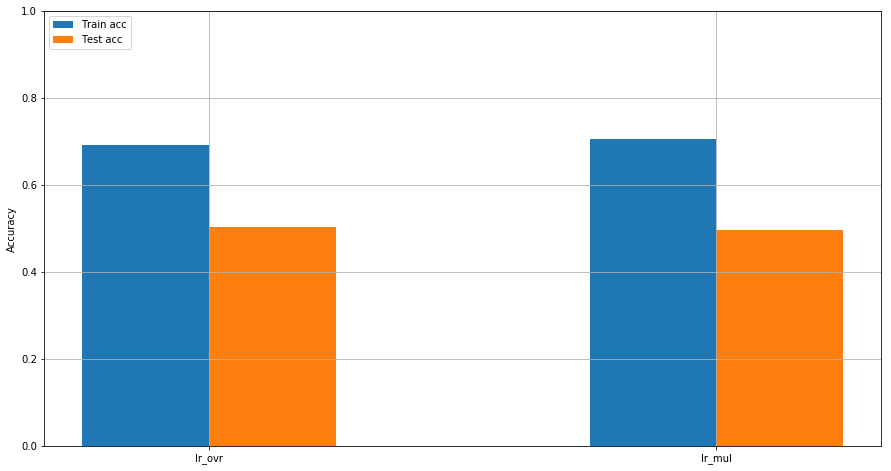

In [44]:
nom = list(['lr_ovr', 'lr_mul'])
pos = list(range(2))
width = 0.25

acc_train_all = np.array(acc_train_all)

fig, ax = plt.subplots(figsize=(15,8))

plt.bar(pos, acc_train_all, width)
plt.bar([p + width for p in pos], acc_test_all, width)

ax.set_ylabel('Accuracy')

ax.set_xticks([p + width*0.5 for p in pos])
ax.set_xticklabels(nom)

plt.ylim([0,1])
plt.legend(['Train acc', 'Test acc'], loc='upper left')
plt.grid()

plt.show()

<p style="font-size: 18px; line-height: 135%;}">
<b>f)</b>
Ambos métodos es decir tanto ovr como multinomial arrojan un resultado similar, siendo ovr un poco mejor en la exactitud de las predicciones para el test set
</p>

<p style="font-size: 25px; line-height: 135%;}">
<b>Parte 3, pregunta m</b>
</p>

In [48]:
acc_train_all = list()
acc_test_all = list()

m_svm_ovr = OneVsRestClassifier(SVC())
m_svm_ovr.fit(cv_train_2, df_train_2.iloc[:, 4])
acc_train_all.append(m_svm_ovr.score(cv_train_2, df_train_2.iloc[:,4]))
acc_test_all.append(m_svm_ovr.score(cv_test_2, df_test_2.iloc[:, 4]))

m_svm_ovo = OneVsOneClassifier(SVC())
m_svm_ovo.fit(cv_train_2, df_train_2.iloc[:, 4])
acc_train_all.append(m_svm_ovo.score(cv_train_2, df_train_2.iloc[:,4]))
acc_test_all.append(m_svm_ovo.score(cv_test_2, df_test_2.iloc[:, 4]))

m_lr_ovr = LogisticRegression()
m_lr_ovr.set_params(multi_class='ovr')
m_lr_ovr.fit(cv_train_2.toarray(), df_train_2.iloc[:, 4])
acc_train_all.append(m_lr_ovr.score(cv_train_2, df_train_2.iloc[:,4]))
acc_test_all.append(m_lr_ovr.score(cv_test_2, df_test_2.iloc[:, 4]))

m_lr_mul = LogisticRegression()
m_lr_mul.set_params(multi_class='multinomial', solver='newton-cg')
m_lr_mul.fit(cv_train_2.toarray(), df_train_2.iloc[:, 4])
acc_train_all.append(m_lr_mul.score(cv_train_2, df_train_2.iloc[:,4]))
acc_test_all.append(m_lr_mul.score(cv_test_2, df_test_2.iloc[:, 4]))

m_mnb = BernoulliNB()
m_mnb.fit(cv_train_2, df_train_2.iloc[:, 4])
acc_train_all.append(m_mnb.score(cv_train_2, df_train_2.iloc[:,4]))
acc_test_all.append(m_mnb.score(cv_test_2, df_test_2.iloc[:, 4]))

m_lda = LinearDiscriminantAnalysis()
m_lda.fit(cv_train_2.toarray(), df_train_2.iloc[:, 4])
acc_train_all.append(m_lda.score(cv_train_2, df_train_2.iloc[:,4]))
acc_test_all.append(m_lda.score(cv_test_2, df_test_2.iloc[:, 4]))


C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


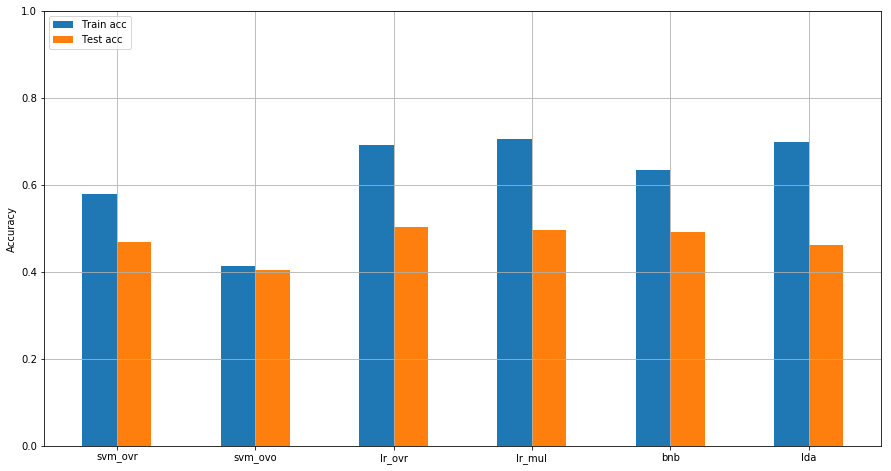

In [50]:
nom = list(['svm_ovr', 'svm_ovo', 'lr_ovr', 'lr_mul', 'bnb', 'lda'])
pos = list(range(6))
width = 0.25

acc_train_all = np.array(acc_train_all)

fig, ax = plt.subplots(figsize=(15,8))

plt.bar(pos, acc_train_all, width)
plt.bar([p + width for p in pos], acc_test_all, width)

ax.set_ylabel('Accuracy')

ax.set_xticks([p + width*0.5 for p in pos])
ax.set_xticklabels(nom)

plt.ylim([0,1])
plt.legend(['Train acc', 'Test acc'], loc='upper left')
plt.grid()

plt.show()

<p style="font-size: 18px; line-height: 135%;}">
<b>f)</b>
Como ya se había visto anteriormente svm es la máquina que peor se comporta, mientras que las otras alcanzan cotas similares. El mejor resultado se obtiene de la máquina de regresión lineal entrenada con el metodo one-vs-rest. Si se tuviera que utilizar una máquina para clasificar polaridad/sentimientos en múltiples clases, lo mejor es hacer un preprocesamiento como el explicado anteriormente y utilizar una máquina de regresión logística extendida a múltiples clases, una de las ventajas es que se trata de una máquina de rápido entrenamiento y gran eficacia. Un criterio para elegir la máquina como se dijo anteriormente es el costo computacional y también se debe ser consiente de si la matriz es mal condicionada en los métodos de lda y qda.
</p>